# Inversion of DC & IP data at the Century Deposit

The Century Deposit is a Zinc-lead-silver deposit is located 250 km to the NNW of the Mt Isa region in Queensland Australia (Location: 18° 43' 15"S, 138° 35' 54"E). 

<img src="./images/Mutton-Figure1-1.png" width=50%>



- https://doi.org/10.1190/1.1444878 

- [geologic background](http://www.portergeo.com.au/database/mineinfo.asp?mineid=mn075)

For background on DC Resistivity Surveys, see [GPG: DC Resistivity](https://gpg.geosci.xyz/content/DC_resistivity/index.html)

In this notebook, we are going to invert the data and see if we can replicate the results presented in [Mutton, 2000](https://doi.org/10.1190/1.1444878). Specifically, we will work with data collected along the line 46800mE. 


## Motivation: replicate inversion results from 20 years ago!

- coarser cells, ... 
- data set is still valuable 

The image below shows the Induced Polarization inversion result generated using the UBC 2D DCIP inversion code that was published in [Mutton, 2000](https://doi.org/10.1190/1.1444878). 

**Can we replicate it with SimPEG?** 

(and update the colorbar 😉)

<img src="images/Mutton-Figure5-1.png" width=80%>

## Step 0: Import Dependencies

Here are links to the documentation for each of the packages we rely on for this tutorial. 

**Core Python / Jupyter**
- [numpy](https://numpy.org/doc/1.18/): arrays
- [matplotlib](https://matplotlib.org/3.2.1/contents.html): plotting
- [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/index.html): interactive widgets in jupyter

**SimPEG ecosystem**
- [discretize](http://discretize.simpeg.xyz/): meshes and differential operators 
- [pymatsolver](http://pymatsolver.rtfd.io/): wrappers on linear solvers
- [SimPEG](http://docs.simpeg.xyz/): Simulation and Parameter Estimation in Geophysics

In [1]:
# core python 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipywidgets

# tools in the simPEG Ecosystem 
import discretize  # for creating computational meshes

# linear solvers
try: 
    from pymatsolver import Pardiso as Solver  # this is a fast linear solver 
except ImportError:
    from SimPEG import SolverLU as Solver  # this will be slower

# SimPEG inversion machinery
from SimPEG import (
    Data, maps,
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives
) 

# DC resistivity and IP modules
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.electromagnetics import induced_polarization as ip

In [2]:
# set the font size in the plots
from matplotlib import rcParams
rcParams["font.size"] = 14

## Step 1: Load the data


**What are our data?**

The survey collected at the Century Deposit uses a dipole-dipole geometry with:
- Current Electrodes (A, B): we refer to the source electrodes as "A" for the positive electrode and "B" for the negative electrode. 
- Potential Electrodes (M, N): we refer to the positive potential electrode as "M" and the negative as "N".

A datum is the potential difference between the M and N electrodes. 

<img src="https://gpg.geosci.xyz/_images/add1.gif">

<img src="https://gpg.geosci.xyz/_images/add2.gif">

The data are stored in the `century` directory. Here, we take a look at what is in that directory. Each folder contains data associated with the named line. 

In [3]:
!ls ./century/

27750N               47000E               Data_in_3D_format
46200E               47200E               geologic_section.csv
46800E               47700E               gmt


We will focus on the `46800E` line. In that directory, there are several files. The `.OBS` files are the observed data. The other files are previous inversion results from the UBC inversion. For the two `.OBS` files: `POT` referrs to "Potentials" - these are our DC data and `IP` referrs to "Induced Polarization". We will start by working with the DC resistivity data and so will load up that file first. 

In [4]:
line = "46800E"
!ls ./century/{line}

dc_data_file = f"./century/{line}/{line[:-1]}POT.OBS"

46800IP.OBS  DCMODA.CON   DCMODA.OUT   IPMODA.CHG   IPMODA.OUT
46800POT.OBS DCMODA.LOG   DCMODA.PRE   IPMODA.LOG   IPMODA.PRE


These file formats are an older version of the UBC DC format and are very similar to the current [UBC DC IP Surface Format](https://giftoolscookbook.readthedocs.io/en/latest/content/fileFormats/dcip2dObsfile.html#surface-format)

```
Comment line: description of data
   n_sources dipole(1) dipole(1) 
     A_location  B_location   n_receivers
   M_location  N_location  measured_potential  standard_deviation
   M_location  N_location  measured_potential  standard_deviation
     A_location  B_location   n_receivers
   M_location  N_location  measured_potential  standard_deviation
   M_location  N_location  measured_potential  standard_deviation
   ....
```

In [5]:
!cat {dc_data_file}

AVG-GDAT 1.22: CENTURY Converted by RES2POT to conductivitie
   27    1    1
    26000.000000    26100.000000           2
   26700.0   26800.0   -.00127    .00006
   26800.0   26900.0   -.00080    .00004
    26100.000000    26200.000000           3
   26700.0   26800.0   -.00164    .00008
   26800.0   26900.0   -.00099    .00005
   26900.0   27000.0   -.00063    .00003
    26200.000000    26300.000000           4
   26700.0   26800.0   -.00252    .00013
   26800.0   26900.0   -.00146    .00007
   26900.0   27000.0   -.00088    .00004
   27000.0   27100.0   -.00125    .00006
    26300.000000    26400.000000           5
   26700.0   26800.0   -.00504    .00025
   26800.0   26900.0   -.00260    .00013
   26900.0   27000.0   -.00147    .00007
   27000.0   27100.0   -.00195    .00010
   27100.0   27200.0   -.00103    .00005
    26400.000000    26500.000000           6
   26700.0   26800.0   -.01048    .00052
   26800.0   26900.0   -.00472    .00024
   26900.0   27000.0   -.00249    .00012
 

Next, we write a function to read in these data. Within SimPEG, there are lots of utilities for reading in data, particularly if they are in common formats such as the more recent UBC formats (e.g. see `dc.utils.readUBC_DC2Dpre`). 

In [6]:
def read_dcip_data(filename):
    """
    Read in a .OBS file from the Century data set into a python dictionary. 
    The format is the old UBC-GIF DCIP format.
    
    Parameters
    ----------
    filename : str
        Path to the file to be parsed
    
    
    Returns
    -------
    dict
        A dictionary with the locations of
        - a_locations: the positive source electrode locations (numpy array) 
        - b_locations: the negative source electrode locations (numpy array) 
        - m_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - observed_data: observed data (list of numpy arrays)
        - standard_deviations: assigned standard deviations (list of numpy arrays)
        - n_sources: number of sources (int)
    
    """
    
    # read in the text file as a numpy array of strings (each row is an entry)
    contents = np.genfromtxt(filename, delimiter=' \n', dtype=np.str)
    
    # the second line has the number of sources, current, and data type (voltages if 1)
    n_sources = int(contents[1].split()[0])
    print(f"number of sources: {n_sources}")
    
    # initialize storage for the electrode locations and data
    a_locations = np.zeros(n_sources)
    b_locations = np.zeros(n_sources)
    m_locations = []
    n_locations = []
    observed_data = []
    standard_deviations = []
    
    # index to track where we have read in content 
    content_index = 1 
    
    # loop over sources 
    for i in range(n_sources):
        # start by reading in the source info 
        content_index = content_index + 1  # read the next line
        a_location, b_location, nrx = contents[content_index].split()  # this is a string

        # convert the strings to a float for locations and an int for the number of receivers
        a_locations[i] = float(a_location)
        b_locations[i] = float(b_location)
        nrx = int(nrx)

        print(f"Source {i}: A-loc: {a_location}, B-loc: {b_location}, N receivers: {nrx}")

        # initialize space for receiver locations, observed data associated with this source
        m_locations_i, n_locations_i = np.zeros(nrx), np.zeros(nrx)
        observed_data_i, standard_deviations_i = np.zeros(nrx), np.zeros(nrx)

        # read in the receiver info 
        for j in range(nrx):
            content_index = content_index + 1  # read the next line
            m_location, n_location, datum, std = contents[content_index].split()

            # convert the locations and data to floats, and store them
            m_locations_i[j] = float(m_location)
            n_locations_i[j] = float(n_location)
            observed_data_i[j] = float(datum)
            standard_deviations_i[j] = float(std)

        # append the receiver info to the lists
        m_locations.append(m_locations_i)
        n_locations.append(n_locations_i)
        observed_data.append(observed_data_i)
        standard_deviations.append(standard_deviations_i)
    
    return {
        "a_locations": a_locations,
        "b_locations": b_locations, 
        "m_locations": m_locations,
        "n_locations": n_locations,
        "observed_data": observed_data, 
        "standard_deviations": standard_deviations,
        "n_sources": n_sources, 
    }

In [7]:
dc_data_dict = read_dcip_data(dc_data_file)

number of sources: 27
Source 0: A-loc: 26000.000000, B-loc: 26100.000000, N receivers: 2
Source 1: A-loc: 26100.000000, B-loc: 26200.000000, N receivers: 3
Source 2: A-loc: 26200.000000, B-loc: 26300.000000, N receivers: 4
Source 3: A-loc: 26300.000000, B-loc: 26400.000000, N receivers: 5
Source 4: A-loc: 26400.000000, B-loc: 26500.000000, N receivers: 6
Source 5: A-loc: 26500.000000, B-loc: 26600.000000, N receivers: 7
Source 6: A-loc: 26600.000000, B-loc: 26700.000000, N receivers: 7
Source 7: A-loc: 26700.000000, B-loc: 26800.000000, N receivers: 6
Source 8: A-loc: 26800.000000, B-loc: 26900.000000, N receivers: 6
Source 9: A-loc: 26900.000000, B-loc: 27000.000000, N receivers: 6
Source 10: A-loc: 27000.000000, B-loc: 27100.000000, N receivers: 6
Source 11: A-loc: 27100.000000, B-loc: 27200.000000, N receivers: 6
Source 12: A-loc: 27200.000000, B-loc: 27300.000000, N receivers: 6
Source 13: A-loc: 27300.000000, B-loc: 27400.000000, N receivers: 6
Source 14: A-loc: 27400.000000, B-lo

In [8]:
for key, value in dc_data_dict.items():
    print(f"{key:<20}: {type(value)}")

a_locations         : <class 'numpy.ndarray'>
b_locations         : <class 'numpy.ndarray'>
m_locations         : <class 'list'>
n_locations         : <class 'list'>
observed_data       : <class 'list'>
standard_deviations : <class 'list'>
n_sources           : <class 'int'>


In [9]:
dc_data_dict["a_locations"]

array([26000., 26100., 26200., 26300., 26400., 26500., 26600., 26700.,
       26800., 26900., 27000., 27100., 27200., 27300., 27400., 27500.,
       27600., 27700., 27800., 27900., 28000., 28100., 28200., 28300.,
       28400., 28500., 28600.])

In [10]:
dc_data_dict["n_sources"]

27

At this point, we have not used anything in SimPEG, this is all pure python. Now, we will look at using SimPEG. 

## Step 2: Create a SimPEG survey

In SimPEG, the `survey` object keeps track of the geometry and type of sources and receivers.  Similar to the way the data file was structured, each `source` takes a `receiver_list` which knows about the different receiver types that are "listening" to that source. 

For example, for the first source, we have dipole receivers at 2 different locations. A SimPEG receiver object can have multiple locations, so conceptually, we can think of a receiver object containing all receivers of one type. If we also had a pole-source, then we would add another receiver type to our receiver list. Since we will run 2D simulations and inversions, then the receivers need to be defined in 2D space `[x, z]`. The receivers are on the surface of the Earth, and in this example, we will not consider topography, so they are at `z=0`.

```python

m_locs = np.array([
    [26700.0, 0.],
    [26800.0, 0.]
])

n_locs = np.array([
    [26800.0, 0.],
    [26900.0, 0.]
])

rx = dc.receivers.Dipole(locations_m=m_locs, locations_n=n_locs) 
rx_list = [rx]

```

Note that in SimPEG, we use column-major / Fortran ordering. So `m_locs[:, 0]` corresponds to all of the x-locations and `m_locs[:, 1]` corresponds to all of the z-locations.  

A source in SimPEG has a single location. For the first source: 
```python 

a_loc = np.r_[26000.0, 0.]
b_loc = np.r_[26100.0, 0.]

src = dc.sources.Dipole(location_a=a_loc, location_b=b_loc, receiver_list=rx_list)
```

Finally, the survey is instantiated with a source list which contains all of the sources and their associated receiver lists
```python
survey = dc.Survey(source_list=[src1, src2, ...])
```

In [11]:
# initialize an empty list for each 
source_list = []

for i in range(dc_data_dict["n_sources"]):
    
    # receiver electrode locations in 2D 
    m_locs = np.vstack([
        dc_data_dict["m_locations"][i], 
        np.zeros_like(dc_data_dict["m_locations"][i])
    ]).T
    n_locs = np.vstack([
        dc_data_dict["n_locations"][i],
        np.zeros_like(dc_data_dict["n_locations"][i])
    ]).T
    
    # construct the receiver object 
    receivers = dc.receivers.Dipole(locations_m=m_locs, locations_n=n_locs)
    
    # construct the source 
    source = dc.sources.Dipole(
        location_a=np.r_[dc_data_dict["a_locations"][i], 0.],
        location_b=np.r_[dc_data_dict["b_locations"][i], 0.],
        receiver_list=[receivers]
    )
    
    # append the new source to the source list
    source_list.append(source)

In [12]:
survey = dc.Survey(source_list=source_list)

### Observed Data 

The data object keeps track of our observed data, the uncertainties and the survey parameters corresponding to each datum. The order of the data and standard deviations should be identical to how we would unwrap the source and receiver lists. E.g.

```
dobs = [d(source1, receiver1), d(source1, receiver2), d(source2, receiver1), ...]
```

Since this is exactly the same order as how we read the data in, we can simply concatenate the data in our dictionary. 

In [13]:
dc_data = Data(
    survey=survey, 
    dobs=np.hstack(dc_data_dict["observed_data"]),
    standard_deviation=np.hstack(dc_data_dict["standard_deviations"])
)

### Visualizing data in a Pseudosection



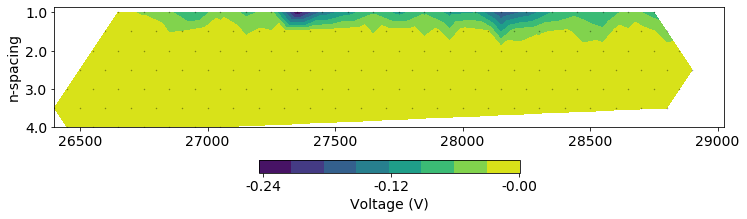

In [14]:
# plot psuedosection
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dc.utils.plot_pseudosection(
    dc_data, data_type="potential",
    plot_type="contourf", data_location=True, ax=ax, 
)
ax.set_aspect(1.5)  # some vertical exxageration

In [15]:
def plot_building_pseudosection(source_ind=0):
    """
    A plotting function to visualize how a pseudosection is built up. 
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    mid_x, mid_z = dc.utils.source_receiver_midpoints(dc_data.survey)
    ax.plot(mid_x, mid_z, '.k', alpha=0.5)
    
    # plot the source location
    a_loc = dc_data_dict["a_locations"][source_ind]
    b_loc = dc_data_dict["b_locations"][source_ind]
    src_mid = (a_loc+b_loc)/2
    ax.plot(np.r_[a_loc, b_loc], np.r_[0, 0], 'C0.')
    ax.plot(src_mid, np.r_[0], 'C0x', ms=6)

    # plot the receiver locations
    m_locs = dc_data_dict["m_locations"][source_ind]
    n_locs = dc_data_dict["n_locations"][source_ind]
    rx_mid = (m_locs+n_locs)/2
    ax.plot(np.r_[m_locs, n_locs], np.zeros(2*len(m_locs)), 'C1.')
    ax.plot(rx_mid, np.zeros_like(m_locs), 'C1x', ms=6)
    
    # plot where the pseudosection points should be 
    pseudo_x = (rx_mid + src_mid)/2.
    pseudo_z = -np.abs(rx_mid-src_mid)/2.
    
    ax.plot(np.r_[src_mid, pseudo_x], np.r_[0, pseudo_z], '-k', alpha=0.3)
    
    for rx_x, px, pz in zip(rx_mid, pseudo_x, pseudo_z): 
        ax.plot(np.r_[px, rx_x], np.r_[pz, 0], '-k', alpha=0.3)
        
    ax.plot(pseudo_x, pseudo_z, 'C2o')
    ax.set_xlabel("Northing (m)")
    ax.set_ylabel("n-spacing")
    
    ax.set_yticklabels([])
    ax.set_xlim([25900, 29300])
    ax.set_aspect(1.5) 
    
    

In [16]:
ipywidgets.interact(
    plot_building_pseudosection, 
    source_ind=ipywidgets.IntSlider(min=0, max=int(dc_data_dict["n_sources"])-1, value=0)
)

interactive(children=(IntSlider(value=0, description='source_ind', max=26), Output()), _dom_classes=('widget-i…

<function __main__.plot_building_pseudosection(source_ind=0)>

### Apparent resistivity

Our measured data are potential differences in units of volts. Both the geometry of the sources and receivers as well as the geology influence these values, having both of these factors influence the values can make it challenging to make sense of the data. In order to translate them to something more interpretable, it is common to work with apparent resistivity values, which are derived by considering the potentials that would be measured if the earth were a half-space: 

$$
\rho_a = \frac{2 \pi \Delta V}{IG}
$$

Where:
- $\rho_a$ is the apparent resistivity ($\Omega$ m)
- $\Delta V$ is the measured potential difference (V)
- $I$ is the source current (A)
- $G$ is the geometric factor which depends on the location of all four electrodes. 
    $$
    G = \left(\frac{1}{r_{AM}} - \frac{1}{r_{BM}} - \frac{1}{r_{AN}} + \frac{1}{r_{BN}} \right)
    $$

Text(0.5, 0, 'Northing (m)')

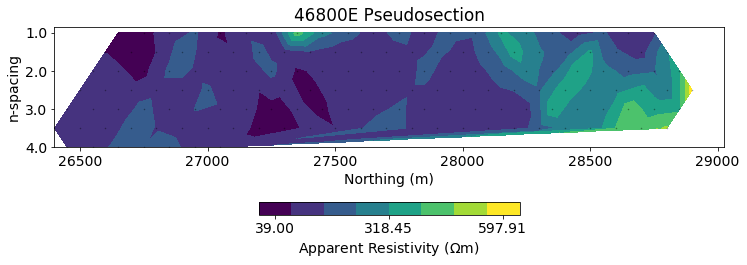

In [17]:
# plot psuedosection
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dc.utils.plot_pseudosection(
    dc_data, data_type="apparent resistivity", 
    plot_type="contourf", data_location=True, ax=ax, cbar_opts={"pad":0.25}
)
ax.set_aspect(1.5)  # some vertical exxageration
ax.set_title(f"{line} Pseudosection")
ax.set_xlabel("Northing (m)")

### Histogram of our data

In addition to looking at a 2D pseudosection of the data, a histogram gives us an idea of the distribution of apparent resistivities. For more complex survey geometries (e.g. fully 3D), it is not always clear how to plot data in a pseudosection form, so histograms are a valueable tool for visualizing data and estimating a good background resistivity for the starting and reference models. 

In [18]:
apparent_resistivity = dc.utils.apparent_resistivity(dc_data)

Text(0, 0.5, 'log$_{10}(\\rho_a)$')

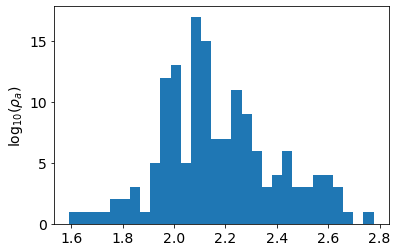

In [19]:
fig, ax = plt.subplots(1, 1)
out = ax.hist(np.log10(apparent_resistivity), bins=30)
ax.set_ylabel("log$_{10}(\\rho_a)$")

estimate a background model 

In [20]:
# rho0 = 10**np.mean(np.log10(apparent_resistivity))
rho0 = np.median(apparent_resistivity)
rho0

135.90619481429147

# Step 3: set up the forward simulation machinery

Now that we have a sense of our data, we will set up a forward simulation which is responsible for simulating predicted data given a model. 

The equations we are solving are 



### Step 1: design a Tensor mesh

In [21]:
min_electrode_spacing = np.min(np.abs(survey.locations_a[:, 0] - survey.locations_b[:, 0]))
n_cells_per_spacing = 4

dx = min_electrode_spacing / n_cells_per_spacing
dz = 0.5 * min_electrode_spacing / n_cells_per_spacing

print(
    f"We will use a base mesh with {dx} m x {dz} m cells"
)

We will use a base mesh with 25.0 m x 12.5 m cells


# TODO: find min / max spacing 

# Add some commentary on boundary conditions 
- problem: Nodal - neuman boundary condition 

In [22]:
domain_x = np.r_[
    survey.electrode_locations[:, 0].min(),
    survey.electrode_locations[:, 0].max()
]

domain_x

array([26000., 29200.])

In [23]:
# find the maximum spacing between source, receiver midpoints
mid_ab = (survey.locations_a + survey.locations_b)/2
mid_mn = (survey.locations_m + survey.locations_n)/2
max_seperation = np.abs(mid_ab - mid_mn).max()
print(f"The maximum seperation is {max_seperation}m")

domain_z = np.r_[-max_seperation/2., 0.]
domain_z

The maximum seperation is 800.0m


array([-400.,    0.])

In [24]:
n_core_extra = 8 
n_core_x = np.ceil(np.diff(domain_x)/dx) + n_core_extra*2  # on each side
n_core_z = np.ceil(np.diff(domain_z)/dz) + n_core_extra  # just below

padding_factor = 1.3
n_pad_x = 8
n_pad_z = 8

In [25]:
hx = [(dx, n_pad_x, -padding_factor), (dx, n_core_x), (dx, n_pad_x, padding_factor)]
hz = [(dz, n_pad_z, -padding_factor), (dz, n_core_z)]

mesh = discretize.TensorMesh([hx, hz])

mesh.x0 = np.r_[
    -mesh.hx[:n_pad_x + n_core_extra].sum() + domain_x.min(),
    -mesh.hy.sum()
]

mesh

TensorMesh: 7,680 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    160     25,024.63     30,175.37     25.00    203.93    1.30
   y     48       -887.69         -0.00     12.50    101.97    1.30

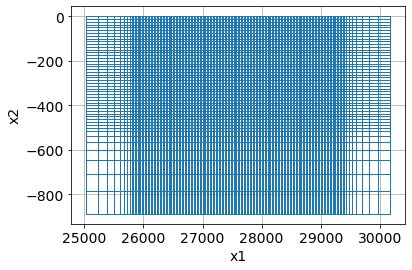

In [26]:
mesh.plotGrid()

## Step 2: Construct the forward simulation

Image of a cell with where things are discretized

In [27]:
# forward simulation 
# Use Exponential Map: m = log(rho)
mapping = maps.ExpMap(mesh)

# Generate 2.5D DC problem
# "N" means potential is defined at nodes
simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, rhoMap=mapping, solver=Solver, survey=survey, storeJ=True
)

In [28]:
%%time 

# run the forward simulation over the half-space & plot apparent resistivities
m0 = np.ones(mesh.nC) * np.log(rho0)
d0 = simulation.make_synthetic_data(m0)

CPU times: user 2.03 s, sys: 154 ms, total: 2.18 s
Wall time: 618 ms


In [29]:
rho0

135.90619481429147

Text(0, 0.5, 'Pseudo-depth')

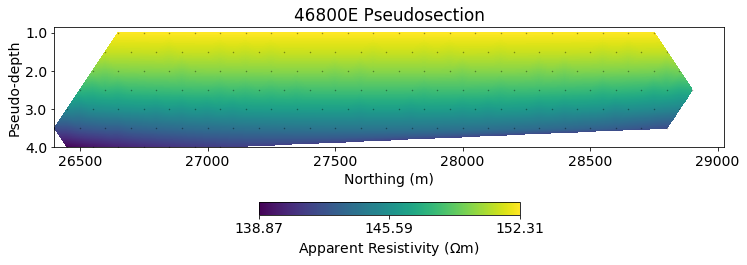

In [40]:
# plot psuedosection
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

clim = np.r_[apparent_resistivity.min(), apparent_resistivity.max()]
dc.utils.plot_pseudosection(
    d0, data_type="apparent resistivity", #clim=clim,
    plot_type="pcolor", data_location=True, ax=ax, 
    cbar_opts={"pad":0.25}
)
ax.set_aspect(1.5)  # some vertical exxageration
ax.set_title(f"{line} Pseudosection")
ax.set_xlabel("Northing (m)")
ax.set_ylabel("Pseudo-depth")


# Set up the inversion

In [31]:
# set up inversion 
dmisfit = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)

# Related to inversion
reg = regularization.Tikhonov(
    mesh, 
    alpha_s=1./mesh.hx.min()**2,
    alpha_x=1, alpha_y=1,
)

In [32]:
opt = optimization.InexactGaussNewton(maxIter=20)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)

# directives
beta = directives.BetaSchedule(coolingFactor=4, coolingRate=2)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = directives.TargetMisfit()

inv = inversion.BaseInversion(
    invProb, directiveList=[
        beta, target, betaest 
    ]
)
opt.remember('xc')

# Run inversion
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.11e+00  1.14e+04  0.00e+00  1.14e+04    2.93e+03      0              
   1  4.11e+00  1.97e+03  4.61e+01  2.16e+03    4.32e+02      0              
   2  1.03e+00  4.83e+02  1.36e+02  6.22e+02    1.18e+02      0   Skip BFGS  
   3  1.03e+00  8.49e+01  2.35e+02  3.26e+02    4.58e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.1353e+03
1 : |xc-x_last| = 2.1219e+00 <= tolX*(1+|x0|) = 4.3146e+01
0 : |proj(x-g)-x|    = 4.5787e+01 <= tol

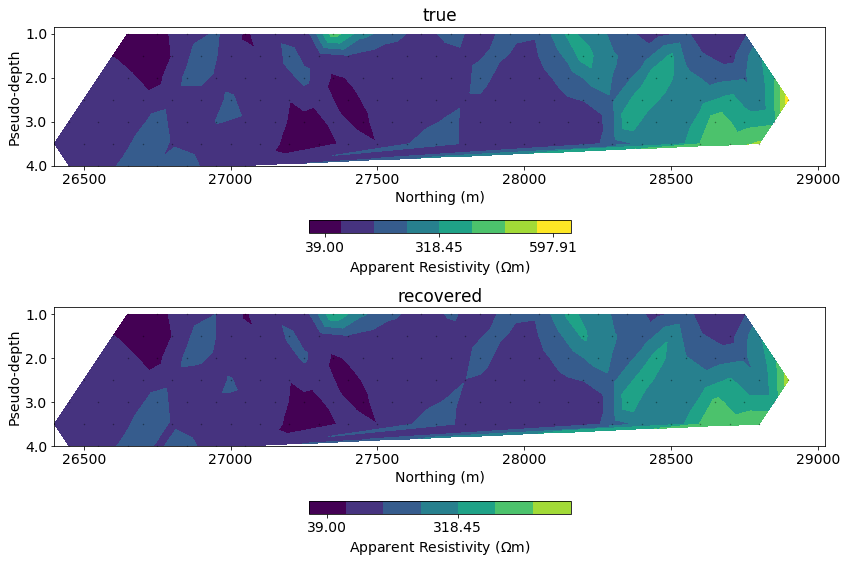

In [33]:
# plot psuedosection
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

clim = np.r_[apparent_resistivity.min(), apparent_resistivity.max()]

for a, data, title in zip(
    ax,
    [dc_data.dobs, invProb.dpred],
    ["true", "recovered"]
): 
    dc.utils.plot_pseudosection(
        dc_data, dobs=data, data_type="apparent resistivity",
        plot_type="contourf", data_location=True, ax=a, 
        cbar_opts={"pad":0.25}, clim=clim
    )
    a.set_title(title)


for a in ax: 
    a.set_aspect(1.5)  # some vertical exxageration
    a.set_xlabel("Northing (m)")
    a.set_ylabel("Pseudo-depth")

plt.tight_layout()



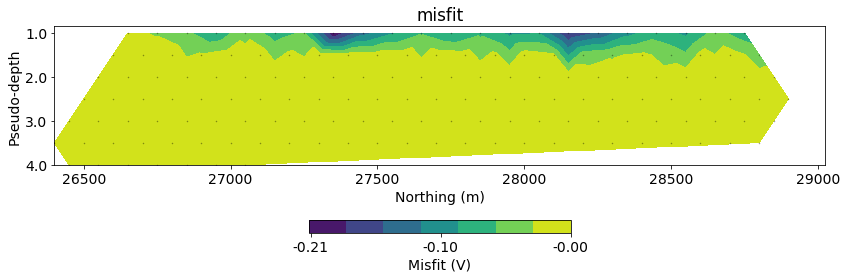

In [34]:
# plot misfit
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

dc.utils.plot_pseudosection(
    dc_data, dobs=invProb.dpred, data_type="misfit",
    plot_type="contourf", data_location=True, ax=ax, 
    cbar_opts={"pad":0.25}
)

ax.set_title("misfit")
ax.set_aspect(1.5)  # some vertical exxageration
ax.set_xlabel("Northing (m)")
ax.set_ylabel("Pseudo-depth")

plt.tight_layout()



In [35]:
# run inversion, plot tikhonov curves

def load_leapfrog_geologic_section(filename="./century/geologic_section.csv"):
    fid = open(filename, 'r')
    lines = fid.readlines()
    data = []
    data_tmp = []
    for line in lines[2:]:
        line_data = (line.split(',')[:3])
        if 'End' in line:
            data.append(np.vstack(data_tmp)[:,[0, 2]])
            data_tmp = []
        else:
            data_tmp.append(np.array(line_data, dtype=float))
    return data

In [36]:
geologic_section = load_leapfrog_geologic_section()

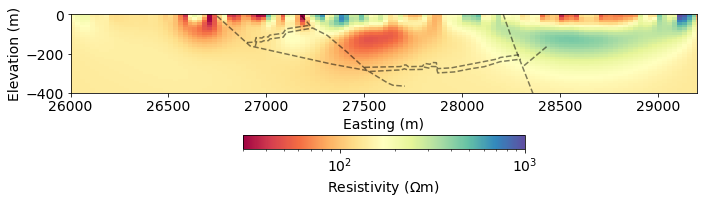

In [37]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
rho = (mapping*mopt)
out = mesh.plotImage(
    rho, pcolorOpts={'norm':LogNorm(), 'cmap':'Spectral'}, ax=ax,
    clim=(30, 1000)
)
for data in geologic_section:
    ax.plot(data[:,0], data[:,1], 'k--', alpha=0.5)
ax.set_xlim(domain_x)
ax.set_ylim((-400, 0))
cb = plt.colorbar(out[0], fraction=0.05, orientation='horizontal', ax=ax)
cb.set_label("Resistivity ($\Omega$m)")
ax.set_aspect(1.)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Elevation (m)')
plt.tight_layout()

<img src="images/Mutton-Figure2-1.png">

# extension to IP

- data sensitive to multiple physical properties 
- linear problem 